# Background

In order to perform a basic in vitro to in vivo extrapolation, we need to predict the fraction unbound for TNT. We will perform a support vector regression to estimate the fraction unbound.

In [1]:
%matplotlib inline

import math
import itertools
import optunity
import optunity.metrics

import pickle

import numpy
import pandas
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import MolToImage
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG

#setting the seed for reproducibility
seed = 10110
numpy.random.seed(seed)

#load the dataset
dataframe = pandas.read_csv("fraction_unbound_chembl.txt", sep="\t")

The next step is to build the fingerprints. For this I am using the RDKit library. I prefer to use Morgan fingerprints for QSAR. Morgan fingerprints are 2-dimensional fingerprints. A circle of a defined radius is used define the neighborhood, and the neighborhood becomes the fingerprint. The RDKit has a far better explanation (http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints).

In [2]:
mols = []
fps = []

#get molecules and then get fingerprints from those
for index, row in dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    mols.append(mol)
    fps.append(fp)

#Convert the RDKit vectors into numpy arrays
#Based on: http://www.rdkit.org/docs/Cookbook.html#using-scikit-learn-with-rdkit
np_fps = []
for fp in fps:
    arr = numpy.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

In [3]:
fraction_unbound = dataframe['fraction_unbound']
fraction_unbound_gt = fraction_unbound.as_matrix()

outer_cv = optunity.cross_validated(x=np_fps_array, y=fraction_unbound_gt, num_folds=10)

def compute_mse_standard(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and default hyperparameters.
    """
    model = SVR(kernel='rbf', C=1e3, gamma=0.1).fit(x_train, y_train)
    predictions = model.predict(x_test)
    return optunity.metrics.mse(y_test, predictions)

# wrap with outer cross-validation
compute_mse_standard = outer_cv(compute_mse_standard)

In [4]:
#RMSE
math.sqrt(compute_mse_standard())

15.249203228986865

I'm pretty happy with the RMSE. The fact that it is 15.4 is largely due to the fact that we have a 6 or 7 chemicals that aren't fit/explained well by the model. Given we started with over 1200 chemicals, I'm not too concerned.

Next, I'm going to fit the full SVR model and save the model object.

In [5]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(np_fps_array, fraction_unbound_gt).predict(np_fps_array)
filename = 'finalized_model.svr_model'
pickle.dump(y_rbf, open(filename, 'wb'))

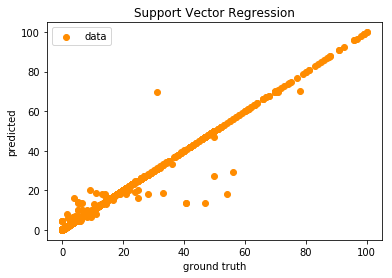

In [6]:
lw = 2
plt.scatter(fraction_unbound_gt, y_rbf, color='darkorange', label='data')
plt.xlabel('ground truth')
plt.ylabel('predicted')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          5.00000000e+00,   1.14400000e+03,   1.60000000e+01,
          6.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

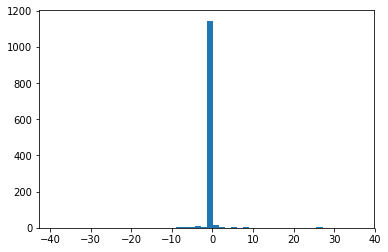

In [7]:
plt.hist(fraction_unbound_gt - y_rbf, bins=50)

In [8]:
tnt_structure = 'CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]'
mol = Chem.MolFromSmiles(tnt_structure)
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
tnt_array = numpy.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, tnt_array)

In [9]:
tnt_array = tnt_array.reshape((1, 2048))

In [10]:
tnt_prediction = svr_rbf.predict(tnt_array)
tnt_prediction

array([ 15.14960561])

In [11]:
residual_array = fraction_unbound_gt - y_rbf
indices = numpy.where(residual_array > 10)
residual_array[indices]


array([ 26.90000861,  36.14987058,  14.20184952,  22.89992937,
        33.15099134,  27.05099134,  27.05099134])

In [12]:
indices

(array([  48,  318,  325,  335, 1014, 1015, 1016]),)

In [13]:
outlier_smiles = dataframe['smiles'][[48, 318, 325, 335, 1014, 1015, 1016]]

In [14]:
np_fps_array[1:]

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [15]:
distances = []
for fp_a in fps:
    distances.append(DataStructs.TanimotoSimilarity(fp_a, fp))


In [16]:
max(distances)

0.14666666666666667

In [17]:
closest_matches = []
i = 0
for distance in distances:
    if distance == min(distances):
        closest_matches.append(i)
    i += 1


In [18]:
dataframe['smiles'][closest_matches]

612    O=C(C1CC12CCN(CC2)C3CCCCC3)N4CCN(CC4)C5CCCCC5
Name: smiles, dtype: object

In [19]:
min(distances)

0.0196078431372549

I'm going to calculate how similar the outlier chemicals are to TNT. First, I want to show the TNT structure, and then I'll show the outlier structures.

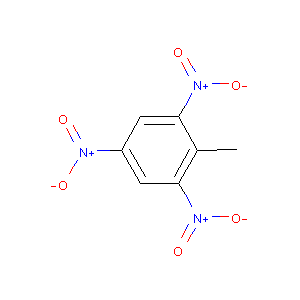

In [20]:
MolToImage(mol)

The TNT structure is listed above.

For a demonstration of what a good match looks like, I'm going to run a similarity map for TNT itself. This will compare the structure of TNT against itself (see below). You'll note that the force fields around the molecule are all green. That means that we have a high degree of match.

(<matplotlib.figure.Figure at 0x7fd260eb4518>, 0.33333333333333337)

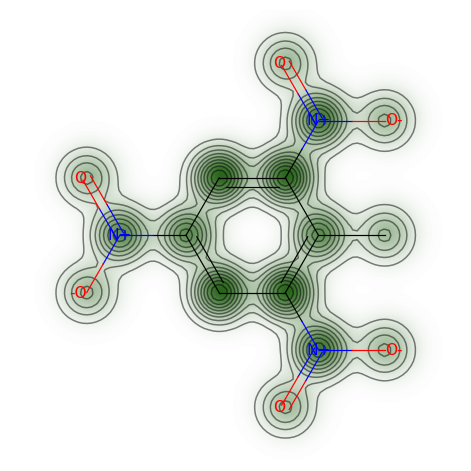

In [21]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, mol, SimilarityMaps.GetMorganFingerprint)

Next, I'm going to show the similarity maps for the outlier chemicals. Red force fields depict areas of very low similarity. Green force fields depict areas that are shared based on Morgan Fingerprints (with a distance of 2).

(<matplotlib.figure.Figure at 0x7fd2910665c0>, 0.03226735811005474)

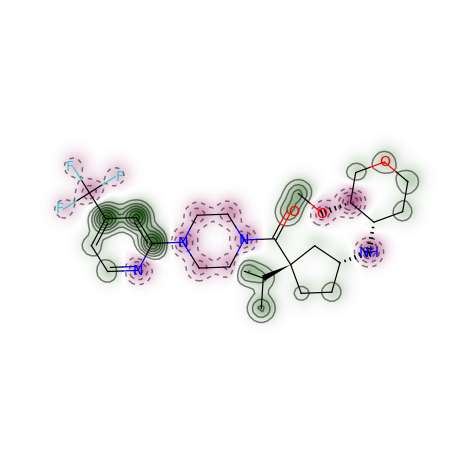

In [22]:
chem_48 = Chem.MolFromSmiles(outlier_smiles.iloc[0])
chem_318 = Chem.MolFromSmiles(outlier_smiles.iloc[1])
chem_325 = Chem.MolFromSmiles(outlier_smiles.iloc[2])
chem_335 = Chem.MolFromSmiles(outlier_smiles.iloc[3])
chem_1014 = Chem.MolFromSmiles(outlier_smiles.iloc[4])
chem_1015 = Chem.MolFromSmiles(outlier_smiles.iloc[5])
chem_1016 = Chem.MolFromSmiles(outlier_smiles.iloc[6])
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_48, SimilarityMaps.GetMorganFingerprint)

(<matplotlib.figure.Figure at 0x7fd291057438>, 0.03516174402250351)

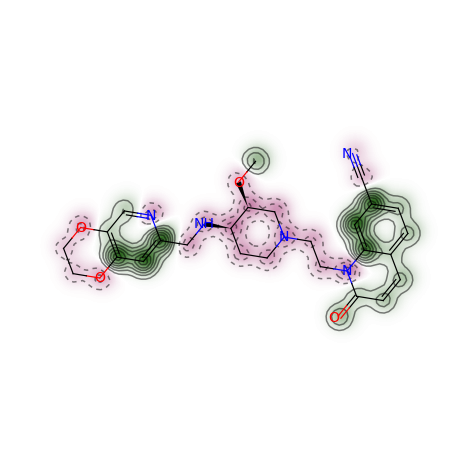

In [23]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_318, SimilarityMaps.GetMorganFingerprint)

(<matplotlib.figure.Figure at 0x7fd260f42da0>, 0.035995160314579555)

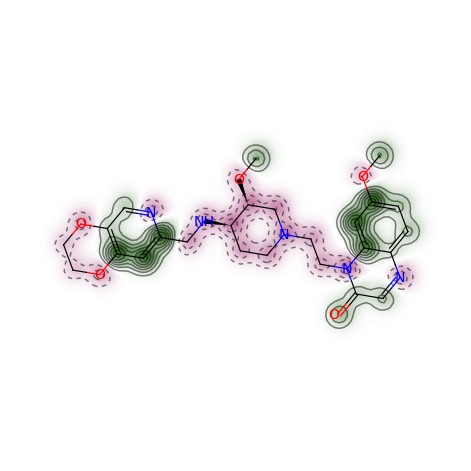

In [24]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_325, SimilarityMaps.GetMorganFingerprint)

(<matplotlib.figure.Figure at 0x7fd29115ceb8>, 0.034093822096898235)

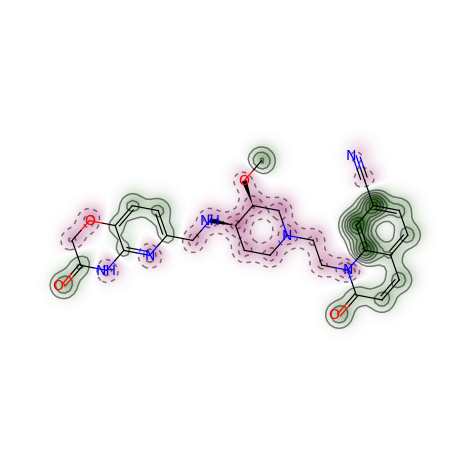

In [25]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_335, SimilarityMaps.GetMorganFingerprint)

(<matplotlib.figure.Figure at 0x7fd270e3c278>, 0.02053915275994865)

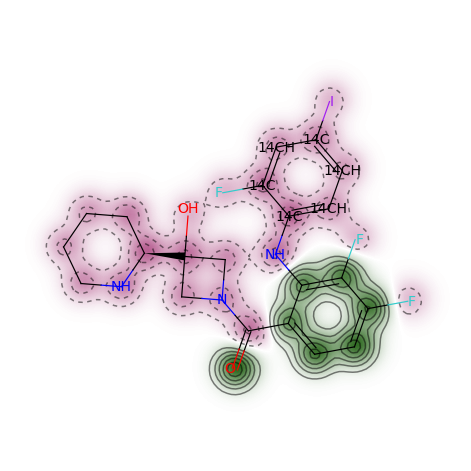

In [26]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_1014, SimilarityMaps.GetMorganFingerprint)


(<matplotlib.figure.Figure at 0x7fd290fbc588>, 0.02053915275994865)

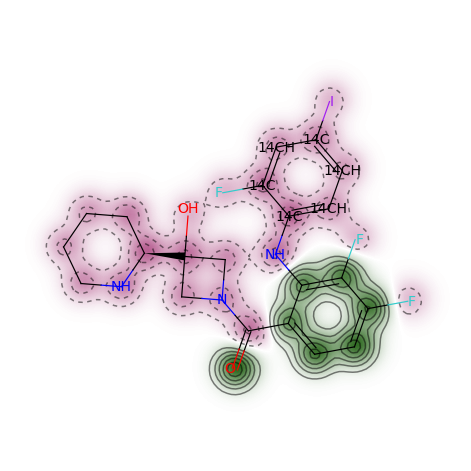

In [27]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_1015, SimilarityMaps.GetMorganFingerprint)


(<matplotlib.figure.Figure at 0x7fd2912475f8>, 0.02053915275994865)

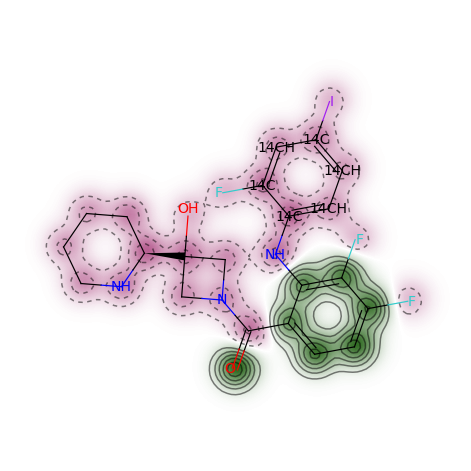

In [28]:
SimilarityMaps.GetSimilarityMapForFingerprint(mol, chem_1016, SimilarityMaps.GetMorganFingerprint)

In [37]:
outlier_smiles.iloc[6]

'OC1(CN(C1)C(=O)c2ccc(F)c(F)c2N[14c]3[14cH][14cH][14c](I)[14cH][14c]3F)[C@@H]4CCCCN4'